In [ ]:
!pip install pdfplumber
!pip install BeautifulSoup

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
from tqdm import tqdm
import os
from glob import glob
import pdfplumber
from datetime import datetime
import yfinance
import numpy as np
import statsmodels.api as sm

from google.colab import drive
drive.mount('/content/drive')


In [ ]:
BASE_URL = "https://www.federalreserve.gov"
MODERN_URL = f"{BASE_URL}/monetarypolicy/fomccalendars.htm"
HISTORICAL_YEARS = range(2010, 1967, -1)
MIDRANGE_YEARS = range(2019, 2010, -1)

MONTH_ORDER = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

def clean_meeting_date(raw):
    if not raw:
        return "UNKNOWN"
    numbers = re.findall(r"\d+", raw)
    if not numbers:
        return "UNKNOWN"
    first_number = numbers[0]
    match = re.search(first_number, raw)
    if match:
        start_index = match.end()
        if '-' in raw[start_index:start_index+2]:
            return str(int(first_number) + 1)
    return first_number

def extract_modern_data():
    response = requests.get(MODERN_URL)
    response.encoding = response.apparent_encoding
    soup = BeautifulSoup(response.text, "html.parser")
    data = []
    for panel in soup.find_all("div", class_="panel panel-default"):
        heading = panel.find("div", class_="panel-heading")
        if not heading:
            continue
        year_match = re.search(r"\d{4}", heading.text)
        if not year_match:
            continue
        year = int(year_match.group())
        for meeting in panel.select("div.fomc-meeting"):
            month_tag = meeting.find("div", class_=lambda c: c and "fomc-meeting__month" in c)
            month = month_tag.text.strip() if month_tag else "UNKNOWN"
            day_tag = meeting.find("div", class_="fomc-meeting__date col-xs-4 col-sm-9 col-md-10 col-lg-1")
            raw_day = day_tag.text.strip() if day_tag else "UNKNOWN"
            day = clean_meeting_date(raw_day)
            statement_url = None
            for div in meeting.find_all("div", class_="col-xs-12 col-md-4 col-lg-2"):
                if "statement" in div.get_text(strip=True).lower():
                    link = div.find("a", href=lambda x: x and x.endswith(".htm") and "/monetary" in x)
                    if link:
                        statement_url = BASE_URL + link["href"]
                        break
            press_url = None
            for div in meeting.find_all("div", class_="col-xs-12 col-md-4 col-lg-3"):
                if "press" in div.get_text(strip=True).lower():
                    link = div.find("a", href=lambda x: x and x.endswith(".htm"))
                    if link:
                        press_url = BASE_URL + link["href"]
                        break
            minutes_url = None
            for div in meeting.find_all("div"):
                if "minutes" in div.text.lower():
                    link = div.find("a", href=lambda x: x and x.endswith(".htm"))
                    if link:
                        minutes_url = BASE_URL + link["href"]
                        break
            data.append({
                "Year": year,
                "Month": month,
                "Date of Meeting": day,
                "Statement_HTML_Url": statement_url,
                "Minutes_HTML_Url": minutes_url,
                "Transcript": None,
                "Press_Conference_HTML_Url": press_url,
                "Internal_Document_URL": None
            })
    return pd.DataFrame(data)

def extract_midrange_data():
    data = []
    for year in MIDRANGE_YEARS:
        url = f"{BASE_URL}/monetarypolicy/fomchistorical{year}.htm"
        try:
            r = requests.get(url)
            soup = BeautifulSoup(r.text, "html.parser")
            panels = soup.find_all("div", class_="panel panel-default panel-padded")
            for panel in panels:
                heading = panel.find("h5", class_="panel-heading panel-heading--shaded")
                if not heading:
                    continue
                raw_text = heading.text.strip()
                month = raw_text.split()[0]
                day = clean_meeting_date(raw_text)
                year_ = int(re.findall(r"\d{4}", raw_text)[-1])
                col_divs = panel.find_all("div", class_="col-xs-12 col-md-6")
                statement_url, minutes_url, transcript_url, internal_doc_url = None, None, None, None
                if len(col_divs) > 0:
                    for p in col_divs[0].find_all("p"):
                        if "statement" in p.get_text(strip=True).lower():
                            link = p.find("a", href=True)
                            if link:
                                statement_url = BASE_URL + link['href']
                                break
                if len(col_divs) > 1:
                    for a in col_divs[1].find_all("a", href=True):
                        if a.text.strip().lower() == "html":
                            minutes_url = BASE_URL + a['href']
                        if a.text.strip().lower() == "pdf" and "/files/" in a['href']:
                            transcript_url = BASE_URL + a['href']
                if year_ >= 1984 and len(col_divs) > 0:
                    beige_links = col_divs[0].find_all("a", href=True)
                    for link in beige_links:
                        href = link["href"]
                        if "beige" in href.lower() and href.endswith(".htm"):
                            internal_doc_url = href if href.startswith("http") else BASE_URL + href
                            break
                    if not internal_doc_url:
                        for link in beige_links:
                            href = link["href"]
                            if "beige" in href.lower() and href.endswith(".pdf"):
                                internal_doc_url = href if href.startswith("http") else BASE_URL + href
                                break
                data.append({
                    "Year": year_,
                    "Month": month,
                    "Date of Meeting": day,
                    "Statement_HTML_Url": statement_url,
                    "Minutes_HTML_Url": minutes_url,
                    "Transcript": transcript_url,
                    "Press_Conference_HTML_Url": None,
                    "Internal_Document_URL": internal_doc_url
                })
        except Exception as e:
            print(f"⚠️ Error in midrange for year {year}: {e}")
            continue
    return pd.DataFrame(data)

def add_transcripts(df):
    for i, row in df.iterrows():
        press_url = row["Press_Conference_HTML_Url"]
        if pd.isna(press_url):
            continue
        try:
            r = requests.get(press_url)
            r.encoding = r.apparent_encoding
            soup = BeautifulSoup(r.text, 'html.parser')
            divs = soup.find_all("div", class_="col-xs-12 col-md-6")
            for div in divs:
                link = div.find("a", href=lambda x: x and x.endswith(".pdf") and "/mediacenter/files/FOMCpresconf" in x)
                if link:
                    df.at[i, "Transcript"] = BASE_URL + link["href"]
                    break
        except:
            continue
    return df

def extract_historical_data():
    data = []
    for year in HISTORICAL_YEARS:
        url = f"{BASE_URL}/monetarypolicy/fomchistorical{year}.htm"
        try:
            r = requests.get(url)
            r.encoding = r.apparent_encoding
            soup = BeautifulSoup(r.text, 'html.parser')
            for panel in soup.find_all("div", class_="panel panel-default"):
                heading = panel.find("div", class_="panel-heading")
                if not heading:
                    continue
                parts = heading.text.strip().split()
                month = parts[0] if parts else "UNKNOWN"
                raw_day = parts[1] if len(parts) > 1 else "UNKNOWN"
                day = clean_meeting_date(raw_day)
                statement_url = None
                minutes_url = None
                transcript_url = None
                internal_doc_url = None
                col_divs = panel.find_all("div", class_="col-xs-12 col-md-6")
                if 1995 <= year <= 2010 and len(col_divs) >= 2:
                    for p in col_divs[1].find_all("p"):
                        if "statement" in p.get_text(strip=True).lower():
                            link = p.find("a", href=lambda x: x and (x.endswith(".htm") or x.endswith("/")))
                            if link:
                                statement_url = BASE_URL + link["href"]
                                break
                if not statement_url and 1992 <= year <= 2003:
                    for div in col_divs:
                        for p in div.find_all("p"):
                            text = p.get_text(strip=True).lower()
                            if "statement" in text and text.endswith("statement"):
                                link = p.find("a", href=lambda x: x and (x.endswith(".htm") or x.endswith("/")))
                                if link:
                                    statement_url = BASE_URL + link["href"]
                                    break
                if year <= 1992 and len(col_divs) >= 2:
                    for link in col_divs[1].find_all("a", href=True):
                        if "record of policy actions" in link.text.lower() and link["href"].endswith(".pdf"):
                            statement_url = BASE_URL + link["href"]
                            break
                for div in col_divs:
                    links = div.find_all("a", href=True)
                    for link in links:
                        if link["href"].endswith("meeting.pdf"):
                            transcript_url = BASE_URL + link["href"]
                        if (
                            "fomcminutes" in link["href"].lower()
                            or "/fomc/minutes/" in link["href"].lower()
                            or "minutes" in link.text.lower()
                        ):
                            minutes_url = BASE_URL + link["href"]
                if not minutes_url and 1968 <= year <= 1996 and len(col_divs) >= 2:
                    for link in col_divs[1].find_all("a", href=True):
                        if "minutes of actions" in link.text.lower() and link["href"].endswith(".pdf"):
                            minutes_url = BASE_URL + link["href"]
                            break
                if not transcript_url and 1968 <= year <= 1976 and len(col_divs) >= 2:
                    for link in col_divs[1].find_all("a", href=True):
                        if "memoranda of discussion" in link.text.lower():
                            transcript_url = BASE_URL + link["href"]
                            break
                if len(col_divs) >= 1:
                    for link in col_divs[0].find_all("a", href=True):
                        if link["href"].endswith(".pdf"):
                            label = link.get_text(strip=True).lower()
                            href = link["href"]
                            if 1968 <= year < 1972 and "greenbook" in href.lower():
                                internal_doc_url = BASE_URL + href
                                break
                            elif 1972 <= year < 1984 and "redbook" in href.lower():
                                internal_doc_url = BASE_URL + href
                                break
                            elif 1984 <= year <= 2010:
                                beige_links = col_divs[0].find_all("a", href=True)
                                for link in beige_links:
                                    href = link["href"]
                                    if "beige" in href.lower() and href.endswith(".htm"):
                                        internal_doc_url = href if href.startswith("http") else BASE_URL + href
                                        break
                                if not internal_doc_url:
                                    for link in beige_links:
                                        href = link["href"]
                                        if "beige" in href.lower() and href.endswith(".pdf"):
                                            internal_doc_url = href if href.startswith("http") else BASE_URL + href
                                            break
                data.append({
                    "Year": year,
                    "Month": month,
                    "Date of Meeting": day,
                    "Statement_HTML_Url": statement_url,
                    "Minutes_HTML_Url": minutes_url,
                    "Transcript": transcript_url,
                    "Press_Conference_HTML_Url": None,
                    "Internal_Document_URL": internal_doc_url
                })
        except Exception as e:
            print(f"⚠️ Error for {year}: {e}")
            continue
    return pd.DataFrame(data)

# --- EXECUTION ---
df_modern = extract_modern_data()
df_modern = add_transcripts(df_modern)
df_midrange = extract_midrange_data()
df_historical = extract_historical_data()
df_final = pd.concat([df_modern, df_midrange, df_historical], ignore_index=True)
df_final.drop(columns=["Press_Conference_HTML_Url"], inplace=True)
df_final = df_final[[
    "Year", "Month", "Date of Meeting",
    "Statement_HTML_Url", "Minutes_HTML_Url", "Transcript", "Internal_Document_URL"
]]
df_final["Month_Num"] = df_final["Month"].map(MONTH_ORDER)
df_final = df_final.sort_values(by=["Year", "Month_Num"]).drop(columns="Month_Num").reset_index(drop=True)

manual_links = {
    607: "https://www.federalreserve.gov/monetarypolicy/beigebook202001.htm",
    609: "https://www.federalreserve.gov/monetarypolicy/beigebook202003.htm",
    614: "https://www.federalreserve.gov/monetarypolicy/beigebook202004.htm",
    615: "https://www.federalreserve.gov/monetarypolicy/beigebook202005.htm",
    616: "https://www.federalreserve.gov/monetarypolicy/beigebook202007.htm",
    617: "https://www.federalreserve.gov/monetarypolicy/beigebook202009.htm",
    619: "https://www.federalreserve.gov/monetarypolicy/beigebook202010.htm",
    620: "https://www.federalreserve.gov/monetarypolicy/beigebook202012.htm",

    621: "https://www.federalreserve.gov/monetarypolicy/beigebook202101.htm",
    622: "https://www.federalreserve.gov/monetarypolicy/beigebook202103.htm",
    623: "https://www.federalreserve.gov/monetarypolicy/beigebook202104.htm",
    624: "https://www.federalreserve.gov/monetarypolicy/beigebook202106.htm",
    625: "https://www.federalreserve.gov/monetarypolicy/beigebook202107.htm",
    626: "https://www.federalreserve.gov/monetarypolicy/beigebook202109.htm",
    627: "https://www.federalreserve.gov/monetarypolicy/beigebook202110.htm",
    628: "https://www.federalreserve.gov/monetarypolicy/beigebook202112.htm",

    629: "https://www.federalreserve.gov/monetarypolicy/beigebook202201.htm",
    630: "https://www.federalreserve.gov/monetarypolicy/beigebook202203.htm",
    631: "https://www.federalreserve.gov/monetarypolicy/beigebook202204.htm",
    632: "https://www.federalreserve.gov/monetarypolicy/beigebook202206.htm",
    633: "https://www.federalreserve.gov/monetarypolicy/beigebook202207.htm",
    634: "https://www.federalreserve.gov/monetarypolicy/beigebook202209.htm",
    635: "https://www.federalreserve.gov/monetarypolicy/beigebook202210.htm",
    636: "https://www.federalreserve.gov/monetarypolicy/beigebook202211.htm",

    637: "https://www.federalreserve.gov/monetarypolicy/beigebook202301.htm",
    638: "https://www.federalreserve.gov/monetarypolicy/beigebook202303.htm",
    639: "https://www.federalreserve.gov/monetarypolicy/beigebook202304.htm",
    640: "https://www.federalreserve.gov/monetarypolicy/beigebook20230531.htm",
    641: "https://www.federalreserve.gov/monetarypolicy/beigebook202307.htm",
    642: "https://www.federalreserve.gov/monetarypolicy/beigebook202309.htm",
    643: "https://www.federalreserve.gov/monetarypolicy/beigebook202310.htm",
    644: "https://www.federalreserve.gov/monetarypolicy/beigebook202311.htm",

    645: "https://www.federalreserve.gov/monetarypolicy/beigebook202401-summary.htm",
    646: "https://www.federalreserve.gov/monetarypolicy/beigebook202402-summary.htm",
    647: "https://www.federalreserve.gov/monetarypolicy/beigebook202404-summary.htm",
    648: "https://www.federalreserve.gov/monetarypolicy/beigebook202405-summary.htm",
    649: "https://www.federalreserve.gov/monetarypolicy/beigebook202407-summary.htm",
    650: "https://www.federalreserve.gov/monetarypolicy/beigebook202408-summary.htm",
    651: "https://www.federalreserve.gov/monetarypolicy/beigebook202410-summary.htm",
    652: "https://www.federalreserve.gov/monetarypolicy/beigebook202411-summary.htm",

    651: "https://www.federalreserve.gov/monetarypolicy/beigebook202501-summary.htm",
    652: "https://www.federalreserve.gov/monetarypolicy/beigebook202502-summary.htm"
}

for idx, link in manual_links.items():
    df_final.at[idx, "Internal_Document_URL"] = link



df_final.to_csv("fomc_calendar_complete_1968_2024.csv", index=False, encoding="utf-8")
print(df_final)

In [ ]:

def extract_html_text(url):
    try:
        r = requests.get(url, timeout=30)
        r.encoding = r.apparent_encoding
        soup = BeautifulSoup(r.text, 'html.parser')
        return soup.get_text(separator=' ', strip=True)
    except Exception as e:
        print(f"⚠️ HTML extraction failed for {url}: {e}")
        return None

def extract_pdf_text(url):
    try:
        r = requests.get(url, stream=True, timeout=30)
        with open("temp.pdf", "wb") as f:
            f.write(r.content)
        with pdfplumber.open("temp.pdf") as pdf:
            text = "\n".join(page.extract_text() or '' for page in pdf.pages)
        os.remove("temp.pdf")
        return text.strip()
    except Exception as e:
        print(f"⚠️ PDF extraction failed for {url}: {e}")
        return None

def format_date(year, month_str, day_str):
    try:
        month_str = month_str.split("/")[-1] if "/" in month_str else month_str
        month_num = datetime.strptime(month_str.strip(), "%B").month
        day = int(day_str)
        if day == 32:
            day = 1
        return f"{int(year):04d}-{month_num:02d}-{day:02d}"
    except:
        return f"{year}-01-01"

def extract_all_texts(df, progress_path="fomc_calendar_text_progress.csv"):
    columns = [
        "Date", "Statement_Text", "Minutes_Text", "Transcript_Text", "Internal_Text",
        "Statement_Chars", "Minutes_Chars", "Transcript_Chars", "Internal_Chars"
    ]
    data = []

    start_idx = 0
    if os.path.exists(progress_path):
        print("🔁 Resuming from saved progress...")
        data = pd.read_csv(progress_path).to_dict('records')
        start_idx = len(data)

    try:
        for i in range(start_idx, len(df)):
            row = df.iloc[i]
            print(f"🔄 Processing row {i + 1}/{len(df)} — {row['Year']} {row['Month']} {row['Date of Meeting']}")

            date = format_date(row['Year'], row['Month'], str(row['Date of Meeting']))

            def get_text(url):
                if pd.isna(url):
                    return None, 0
                text = extract_pdf_text(url) if url.endswith('.pdf') else extract_html_text(url)
                return text, len(text) if text else 0

            s_text, s_len = get_text(row.get("Statement_HTML_Url"))
            m_text, m_len = get_text(row.get("Minutes_HTML_Url"))
            t_text, t_len = get_text(row.get("Transcript"))
            i_text, i_len = get_text(row.get("Internal_Document_URL"))

            data.append({
                "Date": date,
                "Statement_Text": s_text,
                "Minutes_Text": m_text,
                "Transcript_Text": t_text,
                "Internal_Text": i_text,
                "Statement_Chars": s_len,
                "Minutes_Chars": m_len,
                "Transcript_Chars": t_len,
                "Internal_Chars": i_len,
            })

            if (i + 1) % 5 == 0 or i == len(df) - 1:
                pd.DataFrame(data).to_csv(progress_path, index=False)
                print(f"✅ Progress saved at row {i + 1}")

    except KeyboardInterrupt:
        print("...")
        pd.DataFrame(data).to_csv(progress_path, index=False)
        print(f"saved to {progress_path}")

    except Exception as e:
        print(f"error {i + 1}: {e}")
        pd.DataFrame(data).to_csv(progress_path, index=False)
        print("saved after crash")

    finally:
        return pd.DataFrame(data)

df = df_final

df_texts = extract_all_texts(df)
df_texts.to_csv("fomc_calendar_text_extracted.csv", index=False, encoding="utf-8")
print("DONE SAVED TO fomc_calendar_text_extracted.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp fomc_calendar_text_extracted.csv /content/drive/MyDrive/

In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax
from tqdm import tqdm
import os
import re
from glob import glob

# === Google Drive Path ===
SAVE_DIR = "/content/drive/MyDrive/"
BASE_NAME = "fomc_sentiment_scores_progress"
FILE_PATTERN = f"{SAVE_DIR}{BASE_NAME}_*.csv"

# === Load FinBERT ===
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

df_texts = pd.read_csv(f"{SAVE_DIR}fomc_calendar_text_extracted.csv")

MAX_TOKENS = 512


TEXT_COLUMNS = [
    ("Statement_Text", "Statement_Score"),
    ("Minutes_Text", "Minutes_Score"),
    ("Transcript_Text", "Transcript_Score"),
    ("Internal_Text", "Internal_Score"),
]


def split_text(text):
    tokens = tokenizer.encode(text, truncation=False)
    chunks = [tokens[i:i+MAX_TOKENS] for i in range(0, len(tokens), MAX_TOKENS)]
    return [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]


def get_sentiment_score(text):
    if not isinstance(text, str) or text.strip() == "":
        return None
    chunks = split_text(text)
    total_score = 0
    for chunk in chunks:
        inputs = tokenizer(chunk, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        probs = softmax(outputs.logits, dim=1)[0]
        weighted_score = -1 * probs[0].item() + 0 * probs[1].item() + 1 * probs[2].item()
        total_score += weighted_score
    return total_score / len(chunks) if chunks else None


existing_files = sorted(glob(FILE_PATTERN))
if existing_files:
    last_file = existing_files[-1]
    print(f"🔁 Resuming from: {last_file}")
    df_prev = pd.read_csv(last_file)
    output = df_prev.to_dict('records')
    start_idx = len(output)
else:
    output = []
    start_idx = 0
    print("🆕 Starting from scratch")


for idx in tqdm(range(start_idx, len(df_texts)), desc="🔍 FinBERT Sentiment Analysis"):
    row = df_texts.iloc[idx]
    print(f"📊 Processing index {idx} — Date: {row['Date']}")

    result = {"Date": row["Date"]}
    score_sum = 0
    score_count = 0

    for text_col, score_col in TEXT_COLUMNS:
        score = get_sentiment_score(row[text_col])
        result[score_col] = score
        if score is not None:
            score_sum += score
            score_count += 1

    result["Overall_Score"] = score_sum / score_count if score_count > 0 else None
    result["Num_Documents"] = score_count
    output.append(result)


    if (idx + 1) % 5 == 0 or idx == len(df_texts) - 1:
        progress_path = f"{SAVE_DIR}{BASE_NAME}_{idx+1}.csv"
        pd.DataFrame(output).to_csv(progress_path, index=False)
        print(f"💾 Progress saved: {progress_path}")

final_path = f"{SAVE_DIR}fomc_sentiment_scores_final.csv"
df_scores = pd.DataFrame(output)
df_scores.to_csv(final_path, index=False)
print(f"✅ All sentiment scores saved to: {final_path}")

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader.data as web
import datetime
from google.colab import drive
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive', force_remount=True)

In [ ]:

fomc_path = '/content/drive/MyDrive/fomc_sentiment_scores_final.csv'
df = pd.read_csv(fomc_path)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df[df['Date'].notna()].copy()


start_date = df['Date'].min() - relativedelta(days=10)
end_date = df['Date'].max() + relativedelta(days=10)
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Close'].dropna()


sp500.index = pd.to_datetime(sp500.index)

sp500_dates = list(sp500.index)


def calculate_sp500_change(fomc_date):
    try:

        closest_date = sp500.index.asof(fomc_date)
        if pd.isna(closest_date):
            print(f"No trading date found for {fomc_date}")
            return np.nan

        t_index = sp500_dates.index(closest_date)

        if t_index < 4 or t_index + 3 >= len(sp500):
            print(f"Not enough data around {fomc_date} (index {t_index})")
            return np.nan

        price_before = sp500.iloc[t_index - 4]
        price_after = sp500.iloc[t_index + 3]

        result = ((price_after / price_before) - 1) * 100
        return float(result)

    except Exception as e:
        print(f"Error on {fomc_date}: {e}")
        return np.nan

print("Calculating SP500_7Day_Change...")
df['SP500_7Day_Change'] = df['Date'].apply(calculate_sp500_change)

output_path = '/content/drive/MyDrive/fomc_enriched.csv'
df.to_csv(output_path, index=False)
print(f"Saved enriched file to {output_path}")


print(df[['Date', 'Overall_Score', 'SP500_7Day_Change']].head())

In [ ]:

def load_fomc_data():

    file_path = '/content/drive/MyDrive/fomc_enriched.csv'
    df = pd.read_csv(file_path)

    try:

        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


        invalid_dates = df['Date'].isna().sum()
        if invalid_dates > 0:
            print(f"Warning: {invalid_dates} invalid date(s) found in the dataset.")

    except Exception as e:
        print(f"Error parsing dates: {e}")

        def safe_date_parse(date_str):
            try:
                return pd.to_datetime(date_str)
            except:
                print(f"Could not parse date: {date_str}")
                return pd.NaT

        df['Date'] = df['Date'].apply(safe_date_parse)

    return df


def get_vix_data(start_date, end_date):
    try:
        vix_data = yf.download('^VIX', start=start_date, end=end_date)
        return vix_data['Close']
    except Exception as e:
        print(f"Warning: Could not fetch VIX data: {e}")
        return pd.Series()


def get_historical_volatility(start_date, end_date):
    try:

        sp500 = yf.download('^GSPC', start=start_date - relativedelta(days=30), end=end_date)


        returns = sp500['Close'].pct_change()
        volatility = returns.rolling(window=21).std() * np.sqrt(252) * 100  # Annualized and in percentage

        return volatility
    except Exception as e:
        print(f"Error calculating historical volatility: {e}")
        return pd.Series()


def get_inflation_data(start_date, end_date):
    try:

        inflation_data = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)

        inflation_data['Inflation_Rate'] = inflation_data['CPIAUCSL'].pct_change(periods=1) * 100
        return inflation_data
    except Exception as e:
        print(f"Error fetching inflation data: {e}")
        return pd.DataFrame()


def get_fed_funds_rate(start_date, end_date):
    try:
        fed_rate = web.DataReader('FEDFUNDS', 'fred', start_date, end_date)
        return fed_rate
    except Exception as e:
        print(f"Error fetching Fed Funds Rate: {e}")
        return pd.DataFrame()

def get_unemployment_rate(start_date, end_date):
    try:
        unemployment = web.DataReader('UNRATE', 'fred', start_date, end_date)
        return unemployment
    except Exception as e:
        print(f"Error fetching Unemployment Rate: {e}")
        return pd.DataFrame()


def get_treasury_yields(start_date, end_date):
    yields = {}
    try:
        yields['10y'] = web.DataReader('GS10', 'fred', start_date, end_date)

        yields['3m'] = web.DataReader('TB3MS', 'fred', start_date, end_date)

        if '10y' in yields and '3m' in yields:
            yields['curve'] = pd.DataFrame(yields['10y']['GS10'] - yields['3m']['TB3MS'],
                                          columns=['Yield_Curve'])
        return yields
    except Exception as e:
        print(f"Error fetching Treasury yield data: {e}")
        return {}

def get_closest_previous_value(date, time_series):
    try:

        if pd.isna(date):
            return np.nan

        if time_series.empty:
            return np.nan

        previous_values = time_series[time_series.index <= date]
        if previous_values.empty:
            return np.nan

        return previous_values.iloc[-1]
    except Exception as e:
        return np.nan

def enrich_fomc_data(df):

    df = df.copy()
    valid_df = df[df['Date'].notna()]

    if valid_df.empty:
        print("Error: No valid dates found in the dataset.")
        return df

    min_date = valid_df['Date'].min() - relativedelta(months=3)
    max_date = valid_df['Date'].max() + relativedelta(months=3)

    print(f"Data range: {valid_df['Date'].min()} to {valid_df['Date'].max()}")

    print("Fetching VIX data (or historical volatility for pre-1990)...")
    vix_data = get_vix_data(min_date, max_date)
    historical_vol = get_historical_volatility(min_date, max_date)

    print("Fetching inflation data...")
    inflation_data = get_inflation_data(min_date, max_date)

    print("Fetching Fed Funds Rate...")
    fed_rate_data = get_fed_funds_rate(min_date, max_date)

    print("Fetching Unemployment Rate...")
    unemployment_data = get_unemployment_rate(min_date, max_date)

    print("Fetching Treasury yield data...")
    treasury_data = get_treasury_yields(min_date, max_date)

    df['VIX'] = np.nan
    df['Inflation_Rate'] = np.nan
    df['Fed_Funds_Rate'] = np.nan
    df['Unemployment_Rate'] = np.nan

    df['Treasury_10Y'] = np.nan
    df['Treasury_3M'] = np.nan
    df['Yield_Curve'] = np.nan

    for idx, row in valid_df.iterrows():
        date = row['Date']

        df.at[idx, 'VIX'] = get_closest_previous_value(date, vix_data)

        if pd.isna(df.at[idx, 'VIX']):
            df.at[idx, 'VIX'] = get_closest_previous_value(date, historical_vol)

        if not inflation_data.empty and 'Inflation_Rate' in inflation_data:
            df.at[idx, 'Inflation_Rate'] = get_closest_previous_value(date, inflation_data['Inflation_Rate'])


        if not fed_rate_data.empty:
            df.at[idx, 'Fed_Funds_Rate'] = get_closest_previous_value(date, fed_rate_data['FEDFUNDS'])


        if not unemployment_data.empty:
            df.at[idx, 'Unemployment_Rate'] = get_closest_previous_value(date, unemployment_data['UNRATE'])


        if '10y' in treasury_data and not treasury_data['10y'].empty:
            df.at[idx, 'Treasury_10Y'] = get_closest_previous_value(date, treasury_data['10y']['GS10'])

        if '3m' in treasury_data and not treasury_data['3m'].empty:
            df.at[idx, 'Treasury_3M'] = get_closest_previous_value(date, treasury_data['3m']['TB3MS'])

        if 'curve' in treasury_data and not treasury_data['curve'].empty:
            df.at[idx, 'Yield_Curve'] = get_closest_previous_value(date, treasury_data['curve']['Yield_Curve'])

    return df

if __name__ == "__main__":

    print("Loading FOMC sentiment data...")
    fomc_df = load_fomc_data()


    print("\nData loaded successfully:")
    print(f"Shape: {fomc_df.shape}")
    print("\nColumns:")
    print(fomc_df.columns.tolist())
    print("\nSample data:")
    print(fomc_df.head())

    print("\nEnriching FOMC data with financial indicators...")
    enriched_df = enrich_fomc_data(fomc_df)

    output_path = '/content/drive/MyDrive/fomc_sentiment_scores_enriched.csv'
    print(f"\nSaving enriched data to {output_path}...")
    enriched_df.to_csv(output_path, index=False)

Loading FOMC sentiment data...

Data loaded successfully:
Shape: (664, 8)

Columns:
['Date', 'Statement_Score', 'Minutes_Score', 'Transcript_Score', 'Internal_Score', 'Overall_Score', 'Num_Documents', 'SP500_7Day_Change']

Sample data:
        Date  Statement_Score  Minutes_Score  Transcript_Score  \
0 1968-01-09        -0.697125      -0.997612         -0.639953   
1 1968-02-06        -0.465114      -0.998523         -0.684405   
2 1968-03-05        -0.951494      -0.999421         -0.779473   
3 1968-03-14              NaN            NaN               NaN   
4 1968-04-02        -0.694218      -0.992907         -0.730739   

   Internal_Score  Overall_Score  Num_Documents  SP500_7Day_Change  
0       -0.645874      -0.745141              4           1.097526  
1       -0.774152      -0.730549              4          -2.580223  
2       -0.702410      -0.858200              4          -1.165634  
3             NaN            NaN              0          -0.044930  
4       -0.742727     

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Fetching inflation data...
Fetching Fed Funds Rate...
Fetching Unemployment Rate...
Fetching Treasury yield data...

Saving enriched data to /content/drive/MyDrive/fomc_sentiment_scores_enriched.csv...


In [ ]:

data = enriched_df

X = data[['Overall_Score','Fed_Funds_Rate','Inflation_Rate', 'Unemployment_Rate']]
X = sm.add_constant(X)

y = data['Treasury_10Y']
data_clean = pd.concat([X, y], axis=1).dropna()

X_clean = data_clean[X.columns]
y_clean = data_clean[y.name]

model = sm.OLS(y_clean, X_clean).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Treasury_10Y   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     840.7
Date:                Wed, 09 Apr 2025   Prob (F-statistic):          3.81e-223
Time:                        23:13:44   Log-Likelihood:                -765.99
No. Observations:                 516   AIC:                             1542.
Df Residuals:                     511   BIC:                             1563.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0434      0.19

                   Statement_Score  Minutes_Score  Transcript_Score  \
Statement_Score           1.000000       0.047788          0.390681   
Minutes_Score             0.047788       1.000000          0.567436   
Transcript_Score          0.390681       0.567436          1.000000   
Internal_Score            0.200636       0.287206          0.143637   
Overall_Score             0.648880       0.672435          0.693398   
Num_Documents             0.115434      -0.230128         -0.067340   
SP500_7Day_Change         0.089889       0.013112         -0.000497   
VIX                       0.132356       0.441568          0.337088   
Inflation_Rate           -0.000719      -0.395494         -0.246513   
Fed_Funds_Rate            0.258881      -0.488663         -0.127233   
Unemployment_Rate         0.048594      -0.103769         -0.104931   
Treasury_10Y              0.363580      -0.519935         -0.122696   
Treasury_3M               0.268234      -0.499957         -0.143002   
Yield_

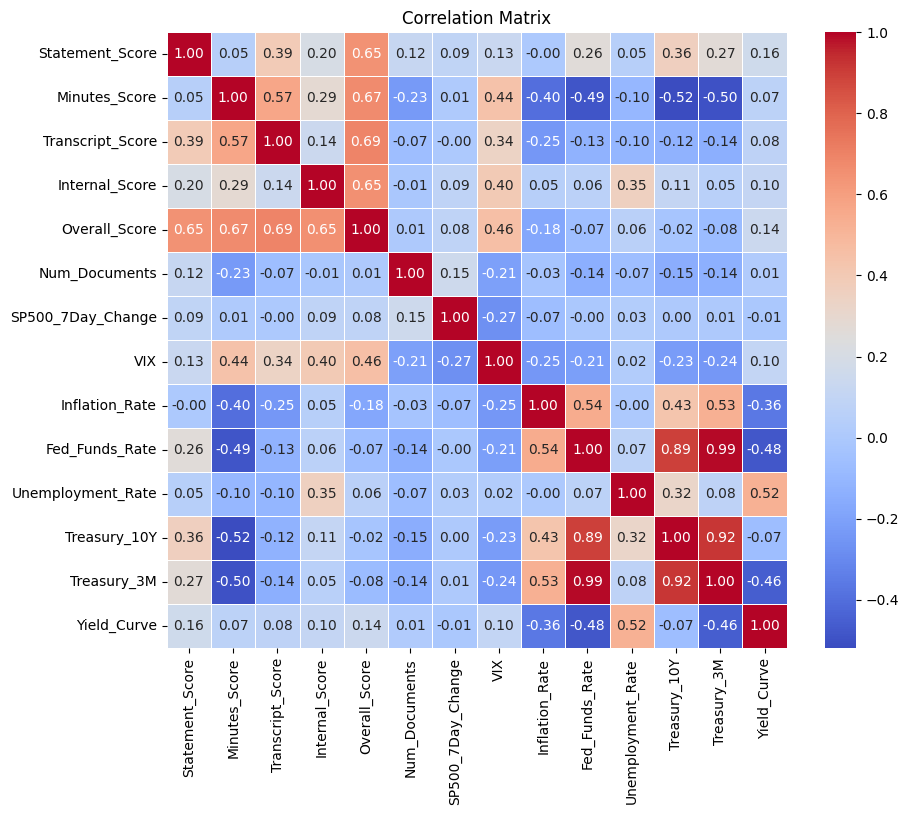

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = enriched_df.corr(numeric_only=True)

print(corr_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()